In [ ]:
!nvidia-smi

Fri Mar 25 11:36:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers


     |████████████████████████████████| 3.8 MB 14.5 MB/s 
     |████████████████████████████████| 6.5 MB 49.3 MB/s 
     |████████████████████████████████| 895 kB 59.0 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#@title Setup & Config
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
df=pd.read_csv("/content/gdrive/MyDrive/nvidmeta/colabv6.csv")

In [ ]:
df.head()

,label,dataset,Text
0,1.0,Master Metaphor List,Even small magnets are sources of magnetism th...
1,1.0,Master Metaphor List,The attractive force of the females' pheromone...
2,1.0,Master Metaphor List,Greed is the strongest evil force at work in t...
3,1.0,Master Metaphor List,It takes a long time for force applied at one ...
4,1.0,Master Metaphor List,The magnetic force pulled at the horseshoe.


In [ ]:
df.shape

(61879, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61880 entries, 0 to 61879
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    61880 non-null  float64
 1   dataset  61880 non-null  object 
 2   Text     61879 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
class_names = ['literal' ,'metaphorical']

In [ ]:
df = df[df['Text'].notna()]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


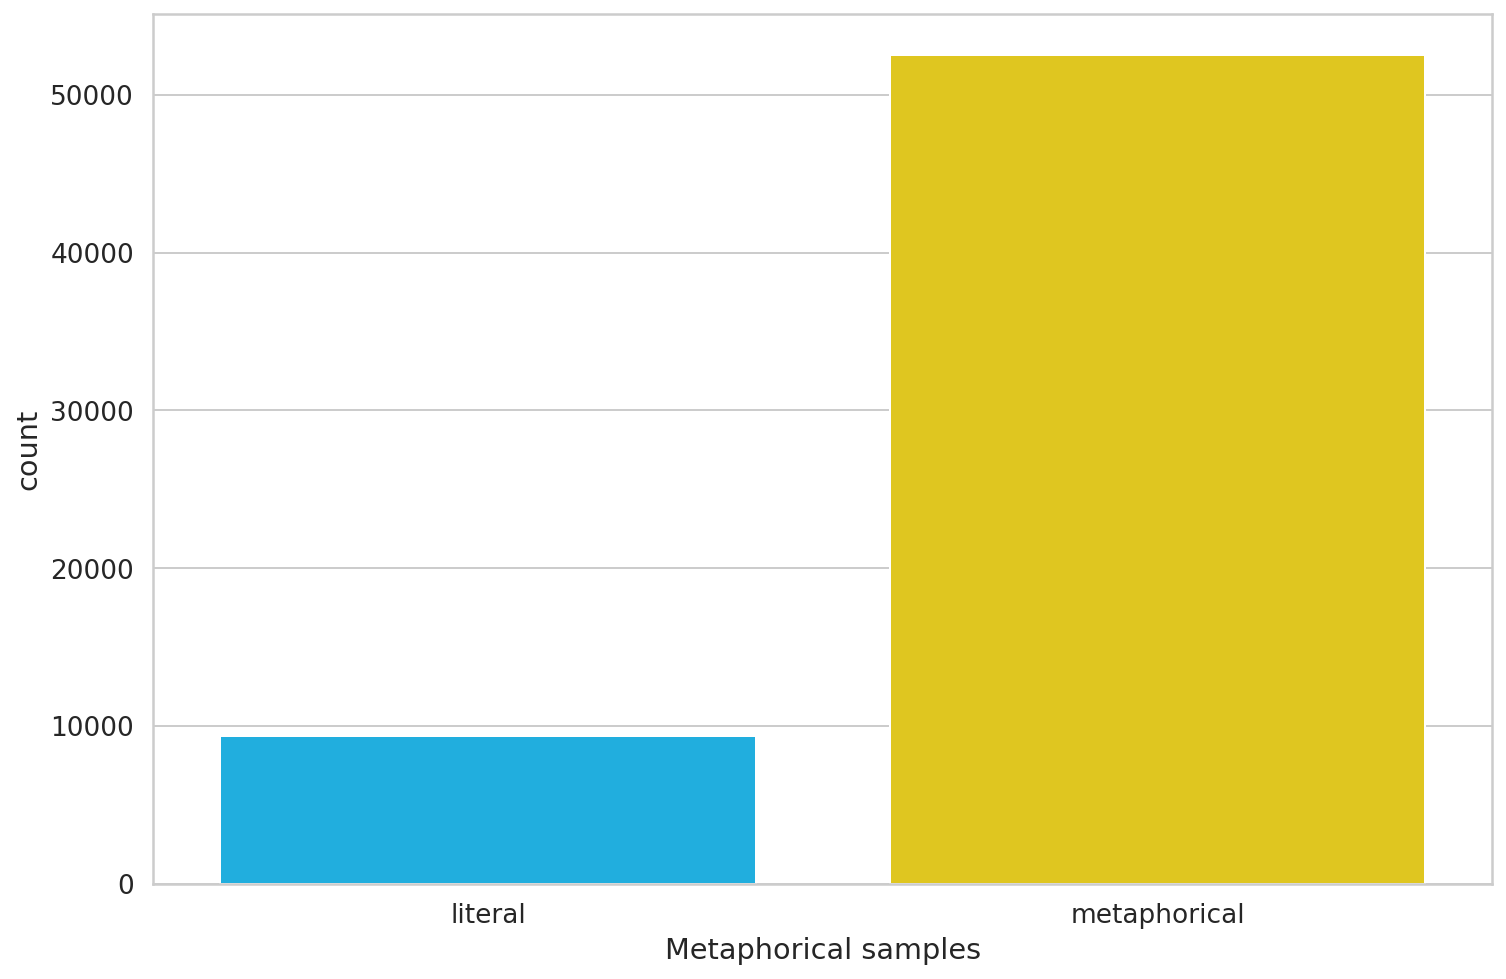

In [ ]:
ax = sns.countplot(df.label)
plt.xlabel('Metaphorical samples')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
sample_txt ='The weather in Hyderabad these days is truly unpredictable.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: The weather in Hyderabad these days is truly unpredictable.
   Tokens: ['The', 'Ġweather', 'Ġin', 'ĠHyder', 'abad', 'Ġthese', 'Ġdays', 'Ġis', 'Ġtruly', 'Ġunpredictable', '.']
Token IDs: [133, 1650, 11, 17502, 7826, 209, 360, 16, 3127, 16110, 4]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([   101,  10117,  35660,  10106,  73047,  11762,  13990,  10124,  92755,
         10119,  88390, 106788,  13096,    119,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'The',
 'weather',
 'in',
 'Hyderabad',
 'these',
 'days',
 'is',
 'truly',
 'un',
 '##pred',
 '##ict',
 '##able',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


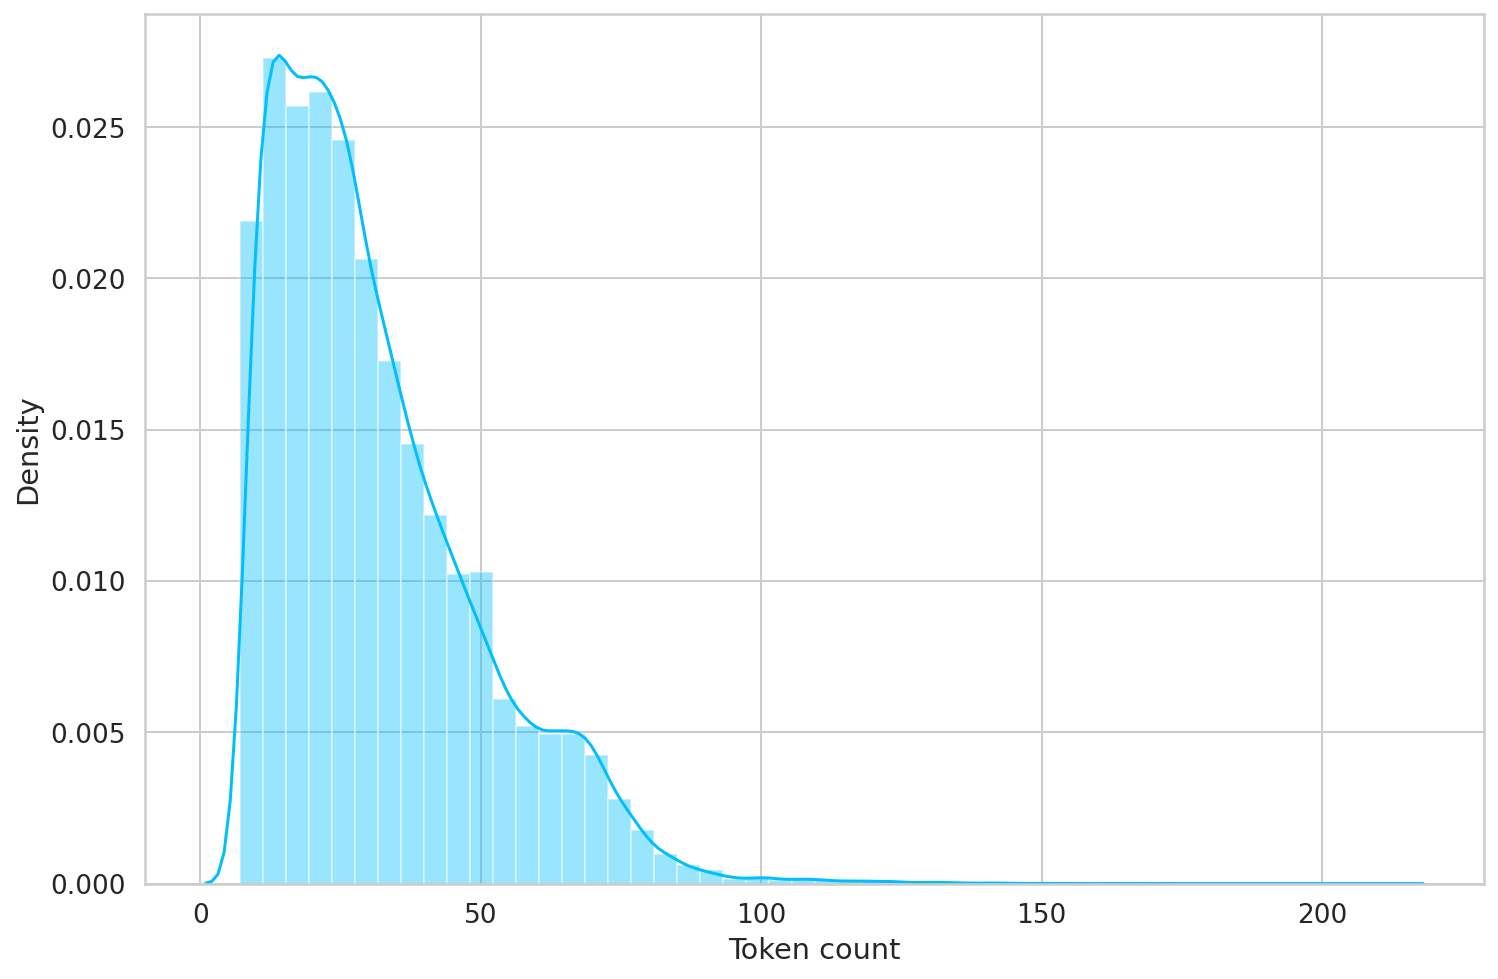

In [ ]:
sns.distplot(token_lens)

plt.xlabel('Token count');


<!-- Since this is a movie tweet dataset, we do expect the text to be quite long. As we can see there seem to be multiple peaks, to capture the whole picture in this case we would optimally want to set the max_length to be 512. 
Note: Bert can handle 512 tokens at max, truncating everything beyond. Due to resource and time restrictions we go with a max length of 250 -->



In [ ]:
MAX_LEN = 80

In [ ]:
class MetaphorDataset(Dataset):

  def __init__(self, tweet_text, targets, tokenizer, max_len):
    self.tweet_text = tweet_text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweet_text)
  
  def __getitem__(self, item):
    tweet = str(self.tweet_text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
#df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape#, df_test.shape

((55691, 3), (6188, 3))

In [ ]:
def seed_worker(worker_id):
    worker_seed = RANDOM_SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(RANDOM_SEED)
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MetaphorDataset(
    tweet_text=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g,
    num_workers=1
    
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = roberta_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
roberta_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class MetaphorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MetaphorClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = MetaphorClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 80])
torch.Size([16, 80])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4057, 0.5943],
        [0.5107, 0.4893],
        [0.5573, 0.4427],
        [0.5250, 0.4750],
        [0.4899, 0.5101],
        [0.5026, 0.4974],
        [0.5212, 0.4788],
        [0.4721, 0.5279],
        [0.4927, 0.5073],
        [0.5253, 0.4747],
        [0.5326, 0.4674],
        [0.5481, 0.4519],
        [0.4960, 0.5040],
        [0.5168, 0.4832],
        [0.4900, 0.5100],
        [0.4673, 0.5327]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [ ]:
EPOCHS = 7

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/nvidmeta/best_model_state_v5.pth')
    best_accuracy = val_acc

Epoch 1/7
----------
Train loss 0.30860379237721225 accuracy 0.8766407498518612
Val   loss 0.2536005534493973 accuracy 0.8981900452488687

Epoch 2/7
----------
Train loss 0.24218488439472904 accuracy 0.9064121671365213
Val   loss 0.29461119086565857 accuracy 0.9122495151906916

Epoch 3/7
----------
Train loss 0.20924605882908004 accuracy 0.9233448851699557
Val   loss 0.28499502493056544 accuracy 0.9169360051712993

Epoch 4/7
----------
Train loss 0.17762321362217592 accuracy 0.9387154118259684
Val   loss 0.29242045993348753 accuracy 0.9193600517129928

Epoch 5/7
----------
Train loss 0.1524396931947335 accuracy 0.9511052055089693
Val   loss 0.2920504341055988 accuracy 0.9200064641241111

Epoch 6/7
----------
Train loss 0.13495714532158784 accuracy 0.9594009804097611
Val   loss 0.28486712943405773 accuracy 0.9221073044602456

Epoch 7/7
----------
Train loss 0.1191198624582985 accuracy 0.9661166077104021
Val   loss 0.28728791535847026 accuracy 0.9235617323852617

CPU times: user 49min 31

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
history


defaultdict(list,
            {'train_acc': [tensor(0.8715, device='cuda:0', dtype=torch.float64),
              tensor(0.9043, device='cuda:0', dtype=torch.float64),
              tensor(0.9213, device='cuda:0', dtype=torch.float64),
              tensor(0.9397, device='cuda:0', dtype=torch.float64),
              tensor(0.9515, device='cuda:0', dtype=torch.float64),
              tensor(0.9591, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.30515881849350585,
              0.2521320099507873,
              0.21030665790993636,
              0.17768725662014873,
              0.15185964798993834,
              0.13359866803573625],
             'val_acc': [tensor(0.9000, device='cuda:0', dtype=torch.float64),
              tensor(0.9099, device='cuda:0', dtype=torch.float64),
              tensor(0.9125, device='cuda:0', dtype=torch.float64),
              tensor(0.9163, device='cuda:0', dtype=torch.float64),
              tensor(0.9152, device='cuda:0', dtype=t

In [ ]:
state_dict = torch.load('best_model_state.pth')
model.load_state_dict(state_dict)
model=model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8737775756197407

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     literal       0.81      0.79      0.80      1406
metaphorical       0.90      0.91      0.91      2991

    accuracy                           0.87      4397
   macro avg       0.86      0.85      0.85      4397
weighted avg       0.87      0.87      0.87      4397



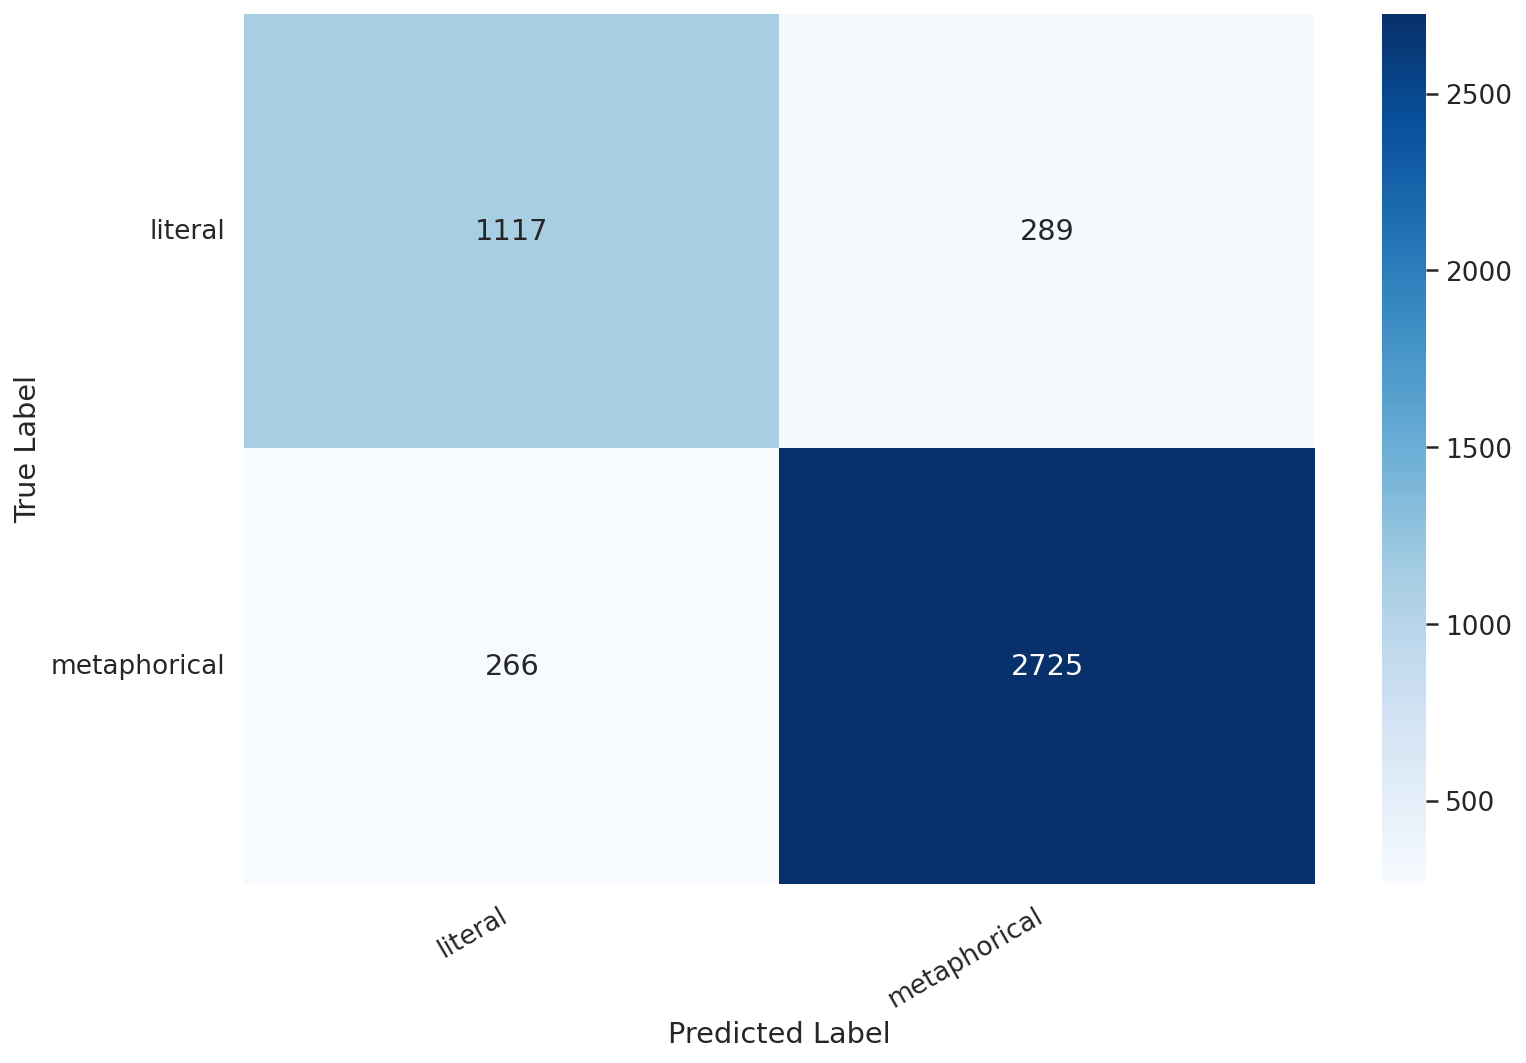

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

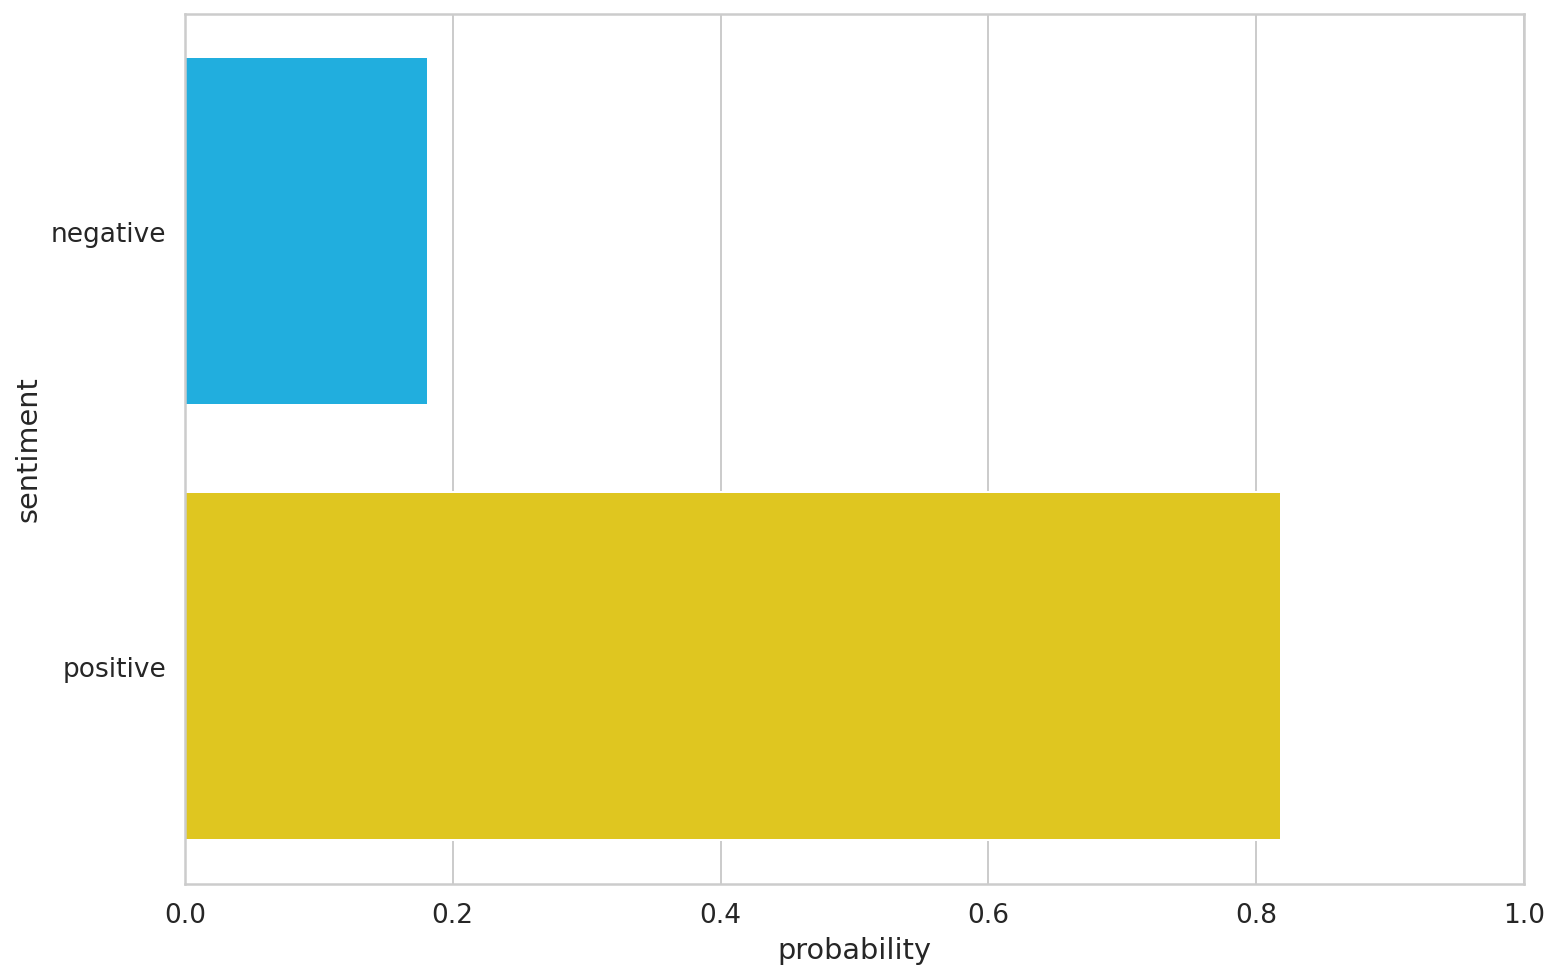

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
tweet_text = "A lot of tweeters here are very biased. I am by no means exaggerating when I say that this is the worst movie I've seen in all of my lifetime!"

In [ ]:
tweet_text = "मैं इस फिल्म की सिफारिश किसी को नहीं करूंगा"

In [ ]:
tweet_text = "फिल्म बहुत खराब थी"

In [ ]:
tweet_text = "فونتش به هم ریختس و نمیشه به راحتی کتاب را خواند"

In [ ]:
encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  truncation=True,
  padding='max_length',
  add_special_tokens=True,
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',
)